# Table of Contents
1 - [Problem Statement](#ps)  
2 - [Overview of Dataset](#dataset)  
3 - [Loading the Data](#load)   
4 - [Exploratory Data Analysis](#eda)   
&emsp;  4.1 - [Data Cleaning: Deduplication](#deduplication)   
5 - [Text Preprocessing Using NLTK](#textprep)  
6 - [Train and Test Split of Data](#split)  
7 - [DecissionTree Classification](#dt)  
&emsp;  7.1 - [Function to find the optimal depth using K-fold cross-validation](#bestdepth)  
&emsp;  7.2 - [Function to predict on Test Data and report Performance](#acc)   
&emsp;  7.3 - [Feature Importance](#fi)  
8 - [Featurization Methods](#vec)  
&emsp;  8.1 - [Bag Of Words(unigram)](#bowuni)   
&emsp;  8.2 - [Bag Of Words(bigram)](#bowbi)  
&emsp;  8.3 - [TF-IDF(unigram)](#tfidfuni)  
&emsp;  8.4 - [TF-IDF(bigram)](#tfidfbi)   
&emsp;  8.5 - [Average Word2Vec](#avgw2v)  
&emsp;  8.6 - [TF-IDF Weighted Word2Vec](#tfidfw2v)  
9 - [Conclusion](#conclusion)

## [1] Problem Statement : <a name="ps"></a>

-  Time Based slicing(100k data points) to split Train Data(70%) and Test Data(30%).
-  Appling Decission Tree model to find the optimal depth using 10 fold Cross Validation(GridSearch) in :  
&emsp; 1)Bag Of Words  
&emsp; 2)TF-IDF  
&emsp; 2)Average Word2Vec  
&emsp; 2)TF-IDF weighted Word2Vec     
-  Comparsion of various performance metrics obtained by various featurization models.    

## [2] Overview of Dataset : <a name="dataset"></a>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.  

Number of reviews: 568,454  
Number of users: 256,059  
Number of products: 74,258  
Timespan: Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10  

Attribute Information:

&emsp;1.Id  
&emsp;2.ProductId - unique identifier for the product  
&emsp;3.UserId - unqiue identifier for the user  
&emsp;4.ProfileName  
&emsp;5.HelpfulnessNumerator - number of users who found the review helpful  
&emsp;6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not  
&emsp;7.Score - rating between 1 and 5  
&emsp;8.Time - timestamp for the review  
&emsp;9.Summary - brief summary of the review  
&emsp;10.Text - text of the review  

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [3] Loading the Data : <a name="load"></a>

In order to load the data, we have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [9]:
#Importing the necessary Packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import time
from tqdm import tqdm
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML
from collections import OrderedDict


from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [10]:
import pickle

#dumping an object to file object using dump method
def dumpfile(a,file_Name):
    fileObject = open(file_Name,"wb")
    pickle.dump(a,fileObject,protocol=2)
    fileObject.close()

#loading an object from file object using load method
def loadfile(file_Name):
    fileObject = open(file_Name,"rb")
    b = pickle.load(fileObject)
    return b


In [11]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
}
</style>

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [7]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [8]:
print("Number of datapoints: ",filtered_data.shape[0])
print("Number of attributes/features: ",filtered_data.shape[1])
HTML(filtered_data.head().to_html(index=False))

Number of datapoints:  525814
Number of attributes/features:  10


Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## [4] Exploratory Data Analysis :<a name="eda"></a>

### [4.1] Data Cleaning: Deduplication <a name="deduplication"></a>
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

<b>Deduplication 1:-</b> As can be seen below the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Deduplication 2:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


<b>Deduplication 3:-</b> It was also seen that a same user has given different reviews for a same product at same time.I think it is normal for a user to give multiple reviews about a product,but that should be in diffrent time.<br>
So,all those rows with same user giving multiple reviews for a same product at same time are considered as duplicate and hence dropped.

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId= "A8891HVRDJAM6" 
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
86221,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",33,33,5,1161388800,Dog LOVE these!,We purchase these dinosaurs constantly. For s...
86236,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",3,3,5,1161388800,Very entertaining!,These dinos are great for powerful chewers! Ou...


In [15]:
final=final.drop_duplicates(subset={"ProductId","UserId","ProfileName","Time"}, keep='first', inplace=False)
print(final.shape)

(363633, 10)


<b>Deduplication 4:-</b> It was also seen that in few rows with Ids from 150493 to 150529 contain reviews regarding books,not fine foods.So I think these should be also removed from the dataset.
After looking at the productid column, it can be noticed that all the observations for fine foods start with B followed by numbers except for Ids from 150493 to 150529. 
I suppose the reviews for book ‘Chicken soup for the soul’ have gotten into the datset mistakenly as they contain the words “chicken soup.

In [16]:
display = final[final.ProductId == "0006641040"]
HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [17]:
final = final[final.ProductId != "0006641040"]

In [18]:
print("Percentage  of data still remaining : ",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

#Before starting the next phase of preprocessing lets see the number of entries left
print("Number of reviews left after Data Cleaning and Deduplication :")
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

Percentage  of data still remaining :  69.14973735959865
Number of reviews left after Data Cleaning and Deduplication :
(363599, 10)


positive    306566
negative     57033
Name: Score, dtype: int64

<b>Observation:-</b>  
It is an imbalanced dataset as the number of positive reviews are way high in number than negative reviews.

## [5] Text Preprocessing Using NLTK : <a name="textprep"></a>

In the Preprocessing phase we do the following in the order below:-

1. Removal of HTML Tags
2. Removal of  any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Removal of  Stopwords
7. Finally Snowball Stemming the word <br>

After which we collect the words used to describe positive and negative reviews

### [5.1] Using SQLite Table to load preprocessed data already saved in disk:

In [12]:
# using the SQLite Table to read data.
conn = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """,conn) 

In [13]:
#Listing out the number of positive and negative reviews
final = final.reset_index(drop=True)
final['Score'].value_counts()

positive    306566
negative     57033
Name: Score, dtype: int64

In [14]:
(final['Score'].value_counts()/len(final['Score']))*100

positive    84.314313
negative    15.685687
Name: Score, dtype: float64

## [6] Train and Test Split of Data : <a name="split"></a>

<b>Sorting the data by Time :</b>

In [15]:
final = final.sample(n = 100000)

final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
387,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
225,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
288,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...
390,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,positive,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,get crazi realli imposs today not find french ...
213,346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,positive,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",great film dont even know sum first complet or...


<b>Time Based Slicing :</b>  
-  Diving the data to Train set(first 70% ie older data) and Test  Set(last 30% ie recent data)

In [16]:
from sklearn.model_selection import train_test_split

X = final["CleanedText"].values
y = final["Score"].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False)

In [17]:
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_train:  (70000,)
Shape of y_train:  (70000,)
Shape of X_test:  (30000,)
Shape of y_test:  (30000,)


## [7] Decission Tree Classification : <a name="dt"></a>

### [7.1] Function to find the optimal depth of Tree Using Training data: <a name="bestdepth"></a>
-  Taking max_depth between range 1 and 30.(so that the tree is not deep and model loses its interpretrability)  
-  Performing 10 fold cross validation(Grid Search) on Train data 
-  Finding the optimal depth
-  Plotting between CV error/CV Accuracy and depth of tree
-  Predicting on Test Data and plotting Confusion Matrix
-  Reporting Performance Metrics

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


depth = np.arange(1,31,2)
param_dt = dict(max_depth = depth)

def DT_model(X_train,y_train):
    
    #Cross validation using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=10)
    
    
    #using class_weight = "balanced" to balance the imbalanced nature of dataset
    model = DecisionTreeClassifier(class_weight = "balanced")
    grid = GridSearchCV(model, param_dt, cv = tscv, scoring = 'f1_weighted')
    grid_estimator = grid.fit(X_train, y_train)
    
    #Finding the optimal alpha
    optimal_depth = grid_estimator.best_params_
    
    #Finding the best score
    grid_mean_scores = [i.mean_validation_score for i in grid_estimator.grid_scores_]
    best_score = grid.best_score_
    
    #CV Scores
    print("\n\033[1mGrid Scores for Model is:\033[0m\n",grid_estimator.grid_scores_)
    print("\n\033[1mBest Parameters:\033[0m ",optimal_depth)
    print("\n\033[1mBest F1-Score:\033[0m {} ".format(np.round(best_score,3)))
    
    
    #Plot 
    plt.figure(figsize = (10,6))
    plt.plot(depth,grid_mean_scores, 'g-o')
    for xy in zip(depth, np.round(grid_mean_scores,3)):
         plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV F1-Score vs Depth of Tree ", fontsize=20, fontweight='bold')
    plt.xlabel("depth", fontsize=16)
    plt.ylabel('CV F1-Score', fontsize=16)
    plt.grid('on')
    
    return grid_estimator

### [7.2] Function to Predict on Test data and report Performance: <a name="acc"></a>

In [19]:
def DT_Test(X_train,X_test,y_train,y_test):
    y_pred = grid_estimator.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred) * 100
    precision = precision_score(y_test,y_pred,average= 'weighted')
    recall = recall_score(y_test,y_pred,average= 'weighted')
    f1= f1_score(y_test,y_pred,average= 'weighted')
    MSE = (1 - (accuracy/100))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_df = pd.DataFrame(cm,
                         index = ['negative','positive'], 
                        columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    print("\033[1mTrue Negative :\033[0m {}".format(tn))
    print("\033[1mFalse Positive :\033[0m {}".format(fp))
    print("\033[1mFalse Negative :\033[0m {}".format(fn))
    print("\033[1mTrue Positive :\033[0m {}".format(tp))
    print("\33[1mPrecission Score :\033[0m {}".format(np.round(precision,3)))
    print("\33[1mRecall Score :\033[0m {}".format(np.round(recall,3)))
    print("\33[1mF1 Score :\033[0m {}".format(np.round(f1,3)))
    print("\n\n")
    
    print('\33[1mClassification Report for Model is :\33[0m')
    classificationreport = classification_report(y_test, y_pred)
    print(classificationreport)

### [7.3] Feature Importance: <a name="fi"></a>

In [20]:
def featureimportance(X_train, y_train, d, vectorizer, n=20):
    clf = DecisionTreeClassifier(max_depth=d,class_weight="balanced") 
    clf.fit(X_train,y_train)
    
    features=clf.feature_importances_
    index = np.argsort(features)[::-1][:n] 
    
    names = vectorizer.get_feature_names()
    names = np.array(names)
    plt.figure(figsize=(20, 6))
    plt.bar(range(n),features[index])
    plt.xticks(range(n),names[index],rotation=90)
    plt.title("Feature Importance", fontsize=20,fontweight="bold")
    plt.grid('on')
    plt.show()

## [8] Featurization Methods : <a name="vec"></a>  

### [8.1] Bag Of Words(unigram) : <a name="bowuni"></a>

In [13]:
%%time
bow_unigram = CountVectorizer(min_df=0.0005)
X_train_bowuni = bow_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowuni))
print("The shape of text BOW vectorizer: ", X_train_bowuni.get_shape())
print("Number of unique word: ", X_train_bowuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (70000, 3932)
Number of unique word:  3932
Wall time: 4.52 s


In [14]:
%%time
X_test_bowuni = bow_unigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowuni.get_shape())
print("Number of unique word: ", X_test_bowuni.get_shape()[1])

The shape of text BOW vectorizer:  (30000, 3932)
Number of unique word:  3932
Wall time: 1.93 s


In [15]:
print("Shape of Training Data: ",X_train_bowuni.shape)
print("Shape of Test Data: ",X_test_bowuni.shape)

Shape of Training Data:  (70000, 3932)
Shape of Test Data:  (30000, 3932)



Grid Scores for Model is:
 [mean: 0.67368, std: 0.09188, params: {'max_depth': 1}, mean: 0.77643, std: 0.01474, params: {'max_depth': 3}, mean: 0.63105, std: 0.01432, params: {'max_depth': 5}, mean: 0.68795, std: 0.02043, params: {'max_depth': 7}, mean: 0.73460, std: 0.00703, params: {'max_depth': 9}, mean: 0.74923, std: 0.00594, params: {'max_depth': 11}, mean: 0.76463, std: 0.01099, params: {'max_depth': 13}, mean: 0.77513, std: 0.01016, params: {'max_depth': 15}, mean: 0.78308, std: 0.00847, params: {'max_depth': 17}, mean: 0.78953, std: 0.00467, params: {'max_depth': 19}, mean: 0.79555, std: 0.00609, params: {'max_depth': 21}, mean: 0.79818, std: 0.00652, params: {'max_depth': 23}, mean: 0.80052, std: 0.00687, params: {'max_depth': 25}, mean: 0.80452, std: 0.00684, params: {'max_depth': 27}, mean: 0.80715, std: 0.00760, params: {'max_depth': 29}]

Best Parameters:  {'max_depth': 29}

Best F1-Score: 0.807 
CPU times: user 14min 20s, sys: 16 ms, total: 14min 20s
Wall time: 14min 20s

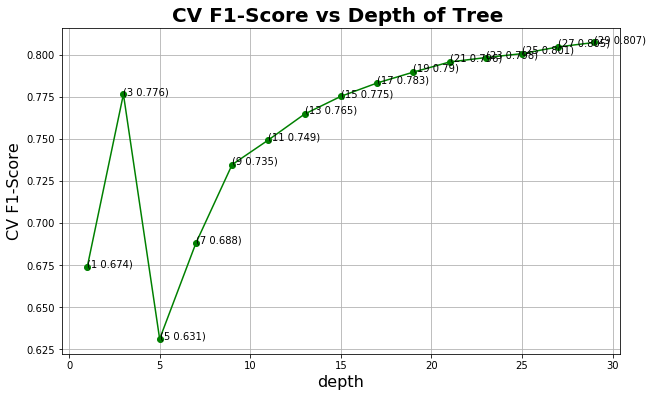

In [25]:
%%time
grid_estimator = DT_model(X_train_bowuni, y_train)

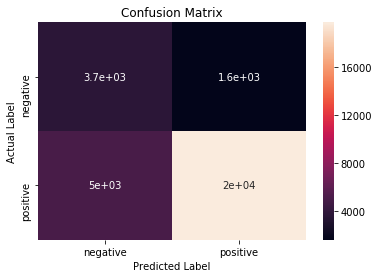

[[ 3671  1589]
 [ 5022 19718]]

Test Error : 0.22
Test Accuracy : 77.963 %
True Negative : 3671
False Positive : 1589
False Negative : 5022
True Positive : 19718
Precission Score : 0.837
Recall Score : 0.78
F1 Score : 0.799



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.42      0.70      0.53      5260
   positive       0.93      0.80      0.86     24740

avg / total       0.84      0.78      0.80     30000

CPU times: user 2.3 s, sys: 16 ms, total: 2.32 s
Wall time: 2.1 s


In [26]:
%%time
DT_Test(X_train_bowuni,X_test_bowuni, y_train,y_test)

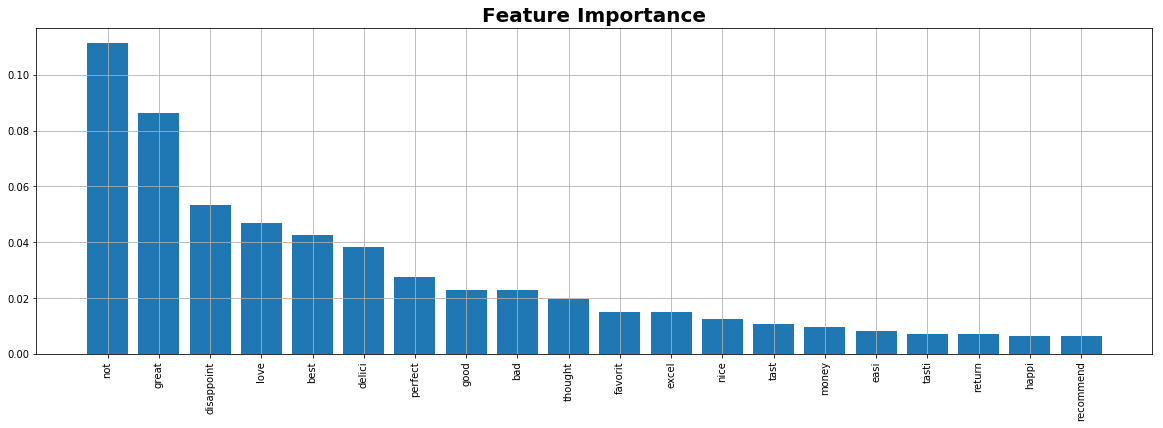

Wall time: 26.6 s


In [16]:
%%time
featureimportance(X_train_bowuni, y_train,20,bow_unigram)

### [8.2] Bag Of Words(bigram) : <a name="bowbi"></a>

In [17]:
%%time
bow_bigram = CountVectorizer(ngram_range=(1, 2),min_df=0.0005)
X_train_bowbi = bow_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowbi))
print("The shape of text BOW vectorizer: ", X_train_bowbi.get_shape())
print("Number of unique word: ", X_train_bowbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (70000, 10975)
Number of unique word:  10975
Wall time: 57 s


In [18]:
%%time
X_test_bowbi = bow_bigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowbi.get_shape())
print("Number of unique word: ", X_test_bowbi.get_shape()[1])

The shape of text BOW vectorizer:  (30000, 10975)
Number of unique word:  10975
Wall time: 6.83 s


In [19]:
print("Shape of Training Data: ",X_train_bowbi.shape)
print("Shape of Test Data: ",X_test_bowbi.shape)

Shape of Training Data:  (70000, 10975)
Shape of Test Data:  (30000, 10975)



Grid Scores for Model is:
 [mean: 0.67368, std: 0.09188, params: {'max_depth': 1}, mean: 0.77643, std: 0.01474, params: {'max_depth': 3}, mean: 0.63403, std: 0.01425, params: {'max_depth': 5}, mean: 0.69126, std: 0.02152, params: {'max_depth': 7}, mean: 0.73642, std: 0.00792, params: {'max_depth': 9}, mean: 0.75343, std: 0.00757, params: {'max_depth': 11}, mean: 0.76948, std: 0.00807, params: {'max_depth': 13}, mean: 0.77988, std: 0.00670, params: {'max_depth': 15}, mean: 0.78798, std: 0.00756, params: {'max_depth': 17}, mean: 0.79435, std: 0.00662, params: {'max_depth': 19}, mean: 0.79858, std: 0.00701, params: {'max_depth': 21}, mean: 0.80351, std: 0.00681, params: {'max_depth': 23}, mean: 0.80779, std: 0.00630, params: {'max_depth': 25}, mean: 0.81023, std: 0.00607, params: {'max_depth': 27}, mean: 0.81311, std: 0.00508, params: {'max_depth': 29}]

Best Parameters:  {'max_depth': 29}

Best F1-Score: 0.813 
CPU times: user 17min 18s, sys: 16 ms, total: 17min 18s
Wall time: 17min 18s

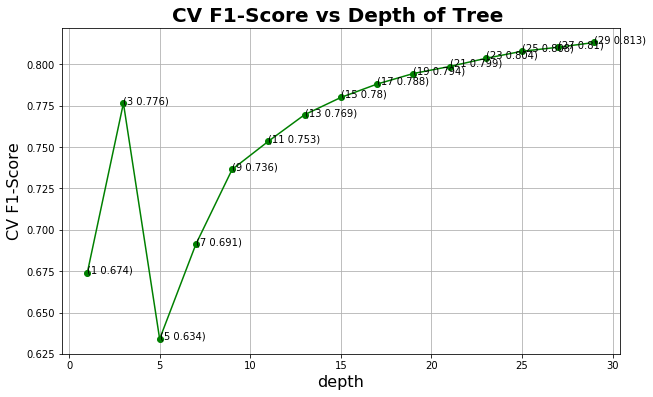

In [33]:
%%time
grid_estimator = DT_model(X_train_bowbi, y_train)

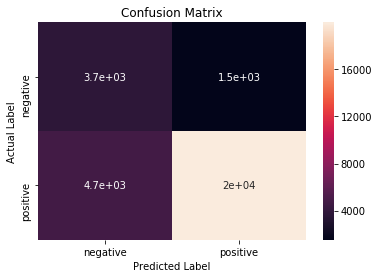

[[ 3736  1524]
 [ 4744 19996]]

Test Error : 0.209
Test Accuracy : 79.107 %
True Negative : 3736
False Positive : 1524
False Negative : 4744
True Positive : 19996
Precission Score : 0.844
Recall Score : 0.791
F1 Score : 0.808



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.44      0.71      0.54      5260
   positive       0.93      0.81      0.86     24740

avg / total       0.84      0.79      0.81     30000

CPU times: user 2.33 s, sys: 20 ms, total: 2.35 s
Wall time: 2.1 s


In [34]:
%%time
DT_Test(X_train_bowbi,X_test_bowbi, y_train, y_test)

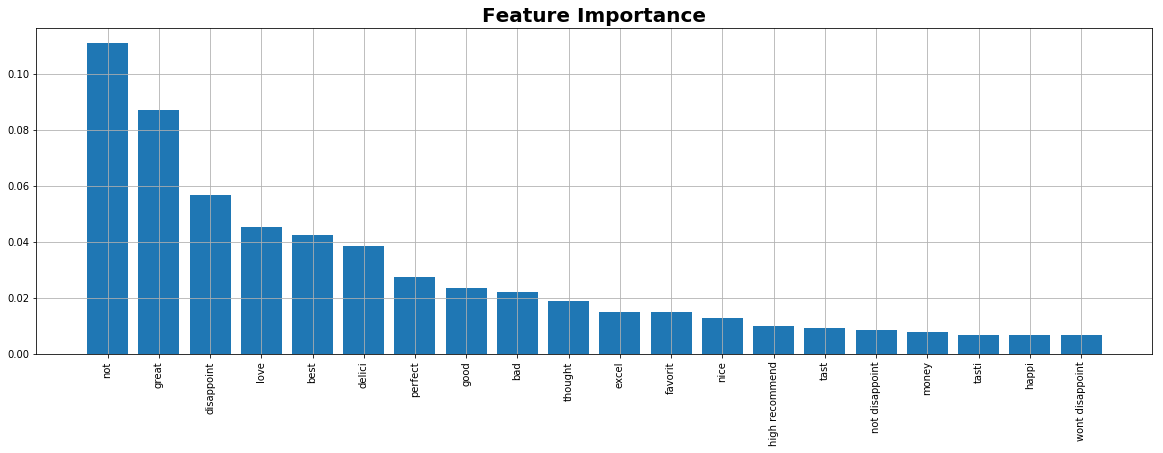

Wall time: 46.5 s


In [20]:
%%time
featureimportance(X_train_bowbi, y_train,20,bow_bigram)

### [8.3] TF-IDF(unigram) : <a name="tfidfuni"></a>

In [21]:
%%time
tfidf_unigram = TfidfVectorizer(min_df = 0.0005)
X_train_tfidfuni = tfidf_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfuni))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfuni.get_shape())
print("Number of unique word: ", X_train_tfidfuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (70000, 3932)
Number of unique word:  3932
Wall time: 7.56 s


In [22]:
%%time
X_test_tfidfuni = tfidf_unigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfuni.get_shape())
print("Number of unique word: ", X_test_tfidfuni.get_shape()[1])

The shape of text TFIDF vectorizer:  (30000, 3932)
Number of unique word:  3932
Wall time: 2.97 s


In [23]:
print("Shape of Training Data: ",X_train_tfidfuni.shape)
print("Shape of Test Data: ",X_test_tfidfuni.shape)

Shape of Training Data:  (70000, 3932)
Shape of Test Data:  (30000, 3932)



Grid Scores for Model is:
 [mean: 0.54518, std: 0.16679, params: {'max_depth': 1}, mean: 0.77336, std: 0.01227, params: {'max_depth': 3}, mean: 0.70594, std: 0.08908, params: {'max_depth': 5}, mean: 0.67422, std: 0.01804, params: {'max_depth': 7}, mean: 0.71106, std: 0.00920, params: {'max_depth': 9}, mean: 0.72707, std: 0.00623, params: {'max_depth': 11}, mean: 0.74333, std: 0.01054, params: {'max_depth': 13}, mean: 0.75593, std: 0.01067, params: {'max_depth': 15}, mean: 0.76731, std: 0.01238, params: {'max_depth': 17}, mean: 0.77694, std: 0.01000, params: {'max_depth': 19}, mean: 0.78173, std: 0.01139, params: {'max_depth': 21}, mean: 0.78706, std: 0.01149, params: {'max_depth': 23}, mean: 0.79248, std: 0.00933, params: {'max_depth': 25}, mean: 0.79735, std: 0.00935, params: {'max_depth': 27}, mean: 0.79994, std: 0.00754, params: {'max_depth': 29}]

Best Parameters:  {'max_depth': 29}

Best F1-Score: 0.8 
CPU times: user 16min 16s, sys: 24 ms, total: 16min 16s
Wall time: 16min 16s


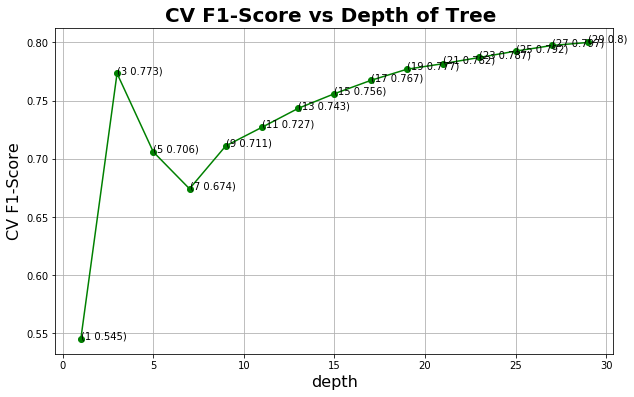

In [40]:
%%time
grid_estimator = DT_model(X_train_tfidfuni, y_train)

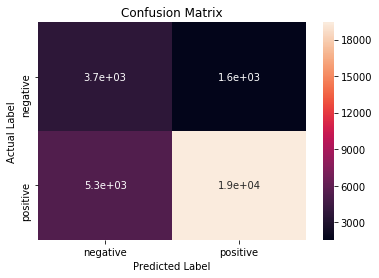

[[ 3688  1572]
 [ 5334 19406]]

Test Error : 0.23
Test Accuracy : 76.98 %
True Negative : 3688
False Positive : 1572
False Negative : 5334
True Positive : 19406
Precission Score : 0.835
Recall Score : 0.77
F1 Score : 0.791



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.41      0.70      0.52      5260
   positive       0.93      0.78      0.85     24740

avg / total       0.83      0.77      0.79     30000

CPU times: user 2.37 s, sys: 20 ms, total: 2.39 s
Wall time: 2.12 s


In [41]:
%%time
DT_Test(X_train_tfidfuni,X_test_tfidfuni,y_train,y_test)

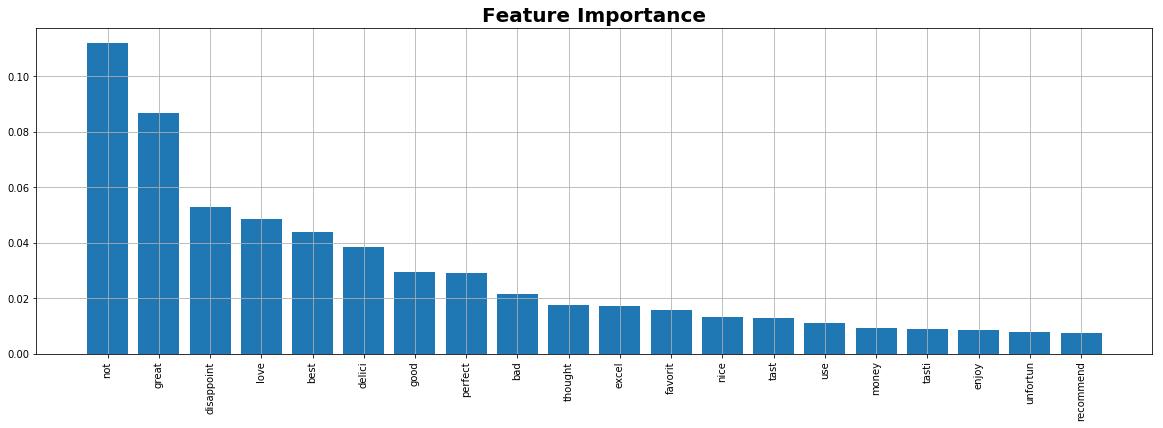

Wall time: 27.7 s


In [30]:
%%time
featureimportance(X_train_tfidfuni, y_train,20,tfidf_unigram)

### [8.4] TF-IDF(bigram) : <a name="tfidfbi"></a>

In [25]:
%%time
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2),min_df = 0.0005)
X_train_tfidfbi = tfidf_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfbi))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfbi.get_shape())
print("Number of unique word: ", X_train_tfidfbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (70000, 10975)
Number of unique word:  10975
Wall time: 22.6 s


In [26]:
%%time
X_test_tfidfbi = tfidf_bigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfbi.get_shape())
print("Number of unique word: ", X_test_tfidfbi.get_shape()[1])

The shape of text TFIDF vectorizer:  (30000, 10975)
Number of unique word:  10975
Wall time: 5.78 s


In [27]:
print("Shape of Training Data: ",X_train_tfidfbi.shape)
print("Shape of Test Data: ",X_test_tfidfbi.shape)

Shape of Training Data:  (70000, 10975)
Shape of Test Data:  (30000, 10975)



Grid Scores for Model is:
 [mean: 0.57822, std: 0.16686, params: {'max_depth': 1}, mean: 0.77712, std: 0.01102, params: {'max_depth': 3}, mean: 0.72900, std: 0.08208, params: {'max_depth': 5}, mean: 0.68646, std: 0.01729, params: {'max_depth': 7}, mean: 0.71703, std: 0.01836, params: {'max_depth': 9}, mean: 0.74014, std: 0.00482, params: {'max_depth': 11}, mean: 0.75675, std: 0.00563, params: {'max_depth': 13}, mean: 0.76963, std: 0.00710, params: {'max_depth': 15}, mean: 0.77932, std: 0.00757, params: {'max_depth': 17}, mean: 0.78900, std: 0.00818, params: {'max_depth': 19}, mean: 0.79277, std: 0.00706, params: {'max_depth': 21}, mean: 0.79690, std: 0.00757, params: {'max_depth': 23}, mean: 0.80275, std: 0.00758, params: {'max_depth': 25}, mean: 0.80536, std: 0.00676, params: {'max_depth': 27}, mean: 0.80880, std: 0.00681, params: {'max_depth': 29}]

Best Parameters:  {'max_depth': 29}

Best F1-Score: 0.809 
CPU times: user 19min 32s, sys: 20 ms, total: 19min 32s
Wall time: 19min 32s

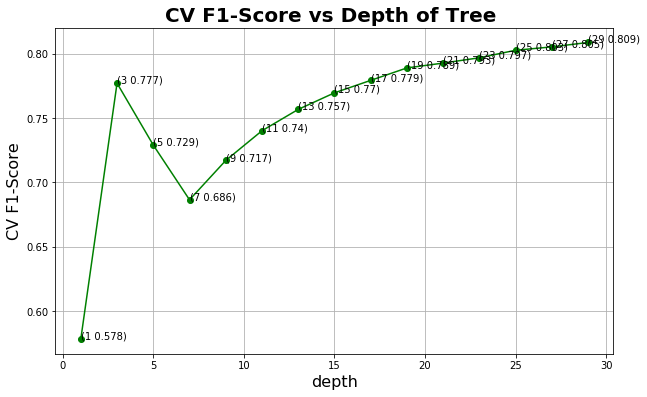

In [47]:
%%time
grid_estimator = DT_model(X_train_tfidfbi, y_train)

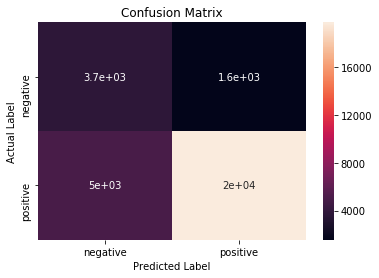

[[ 3695  1565]
 [ 5022 19718]]

Test Error : 0.22
Test Accuracy : 78.043 %
True Negative : 3695
False Positive : 1565
False Negative : 5022
True Positive : 19718
Precission Score : 0.838
Recall Score : 0.78
F1 Score : 0.799



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.42      0.70      0.53      5260
   positive       0.93      0.80      0.86     24740

avg / total       0.84      0.78      0.80     30000

CPU times: user 2.36 s, sys: 20 ms, total: 2.38 s
Wall time: 2.12 s


In [48]:
%%time
DT_Test(X_train_tfidfbi,X_test_tfidfbi,y_train,y_test)

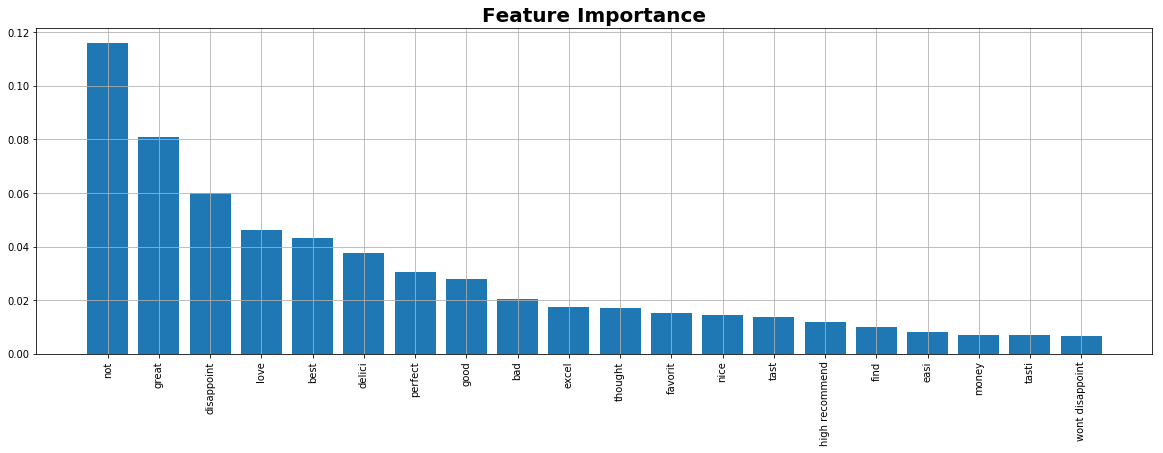

Wall time: 40.4 s


In [28]:
%%time
featureimportance(X_train_tfidfbi, y_train,20,tfidf_bigram)

## [8.5] Average Word2Vec : <a name="avgw2v"></a>

In [21]:
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())

In [22]:
print(X_train[0])
print("****************************************************************************")
print(list_of_sent_train[0])

beetlejuic well written movi everyth excel act special effect delight chose view movi
****************************************************************************
['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'movi']


In [23]:
%%time
## Word2Vec Model considering only those words that occur atleast 5 times in the corpus
min_count = 5
w2v_model = Word2Vec(list_of_sent_train, min_count = min_count, size = 200, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

CPU times: user 59.8 s, sys: 80 ms, total: 59.8 s
Wall time: 16.5 s


In [24]:
w2v_words = list(w2v_model.wv.vocab)

In [25]:
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())

In [26]:
print(X_test[5])
print("****************************************************************************")
print(list_of_sent_test[5])

husband realli like cocoa add extra milk cup creamier flavor conveni cannot beat
****************************************************************************
['husband', 'realli', 'like', 'cocoa', 'add', 'extra', 'milk', 'cup', 'creamier', 'flavor', 'conveni', 'cannot', 'beat']


In [25]:
%%time
X_train_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [04:47<00:00, 243.48it/s]


Wall time: 4min 47s


In [26]:
%%time
X_test_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [02:24<00:00, 207.14it/s]


Wall time: 2min 24s


In [27]:
#Checking NAN in test data if any
np.any(np.isnan(X_test_avgw2v))

False

In [28]:
print("Number of rows in Train Data: ",len(X_train_avgw2v))
print("Number of features in Train Data: ",len(X_train_avgw2v[0]))
print("Number of rows in Test Data: ",len(X_test_avgw2v))
print("Number of features in Test Data: ",len(X_test_avgw2v[0]))

Number of rows in Train Data:  70000
Number of features in Train Data:  200
Number of rows in Test Data:  30000
Number of features in Test Data:  200



Grid Scores for Model is:
 [mean: 0.71002, std: 0.01557, params: {'max_depth': 1}, mean: 0.70846, std: 0.02177, params: {'max_depth': 3}, mean: 0.75682, std: 0.02534, params: {'max_depth': 5}, mean: 0.77891, std: 0.01780, params: {'max_depth': 7}, mean: 0.79428, std: 0.01927, params: {'max_depth': 9}, mean: 0.80898, std: 0.01817, params: {'max_depth': 11}, mean: 0.82062, std: 0.01512, params: {'max_depth': 13}, mean: 0.82649, std: 0.01474, params: {'max_depth': 15}, mean: 0.82803, std: 0.01287, params: {'max_depth': 17}, mean: 0.82989, std: 0.01413, params: {'max_depth': 19}, mean: 0.82964, std: 0.01389, params: {'max_depth': 21}, mean: 0.82974, std: 0.01424, params: {'max_depth': 23}, mean: 0.82981, std: 0.01420, params: {'max_depth': 25}, mean: 0.83013, std: 0.01522, params: {'max_depth': 27}, mean: 0.82936, std: 0.01509, params: {'max_depth': 29}]

Best Parameters:  {'max_depth': 27}

Best F1-Score: 0.83 
CPU times: user 30min 39s, sys: 8 ms, total: 30min 39s
Wall time: 30min 39s


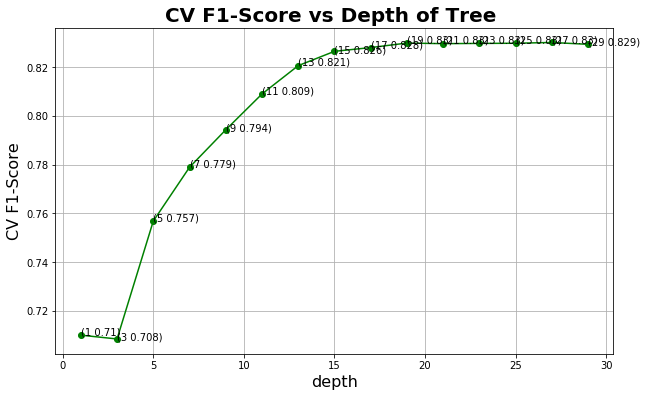

In [61]:
%%time
grid_estimator = DT_model(X_train_avgw2v,y_train)

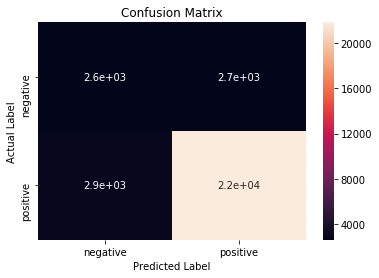

[[ 2602  2658]
 [ 2913 21827]]

Test Error : 0.186
Test Accuracy : 81.43 %
True Negative : 2602
False Positive : 2658
False Negative : 2913
True Positive : 21827
Precission Score : 0.818
Recall Score : 0.814
F1 Score : 0.816



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.47      0.49      0.48      5260
   positive       0.89      0.88      0.89     24740

avg / total       0.82      0.81      0.82     30000

CPU times: user 2.4 s, sys: 0 ns, total: 2.4 s
Wall time: 2.14 s


In [62]:
%%time
DT_Test(X_train_avgw2v,X_test_avgw2v,y_train,y_test)

## [8.6] TF-IDF Weighted Word2Vec : <a name="tfidfw2v"></a>

In [27]:
%%time
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2),min_df=0.0005)
X_train_tfidfbi = tfidf_bigram.fit_transform(X_train)

CPU times: user 11.8 s, sys: 140 ms, total: 11.9 s
Wall time: 11.9 s


In [28]:
dictionary = dict(zip(tfidf_bigram.get_feature_names(),list(tfidf_bigram.idf_)))

In [30]:
%%time
tfidf_feat = tfidf_bigram.get_feature_names() # tfidf words/col-names
X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(200)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [02:17<00:00, 510.54it/s]

CPU times: user 2min 17s, sys: 5.1 s, total: 2min 22s
Wall time: 2min 17s


In [31]:
%%time
X_test_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(200)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [01:02<00:00, 483.05it/s]

CPU times: user 1min 2s, sys: 2.62 s, total: 1min 4s
Wall time: 1min 2s


In [32]:
print("Number of rows in Train Data: ",len(X_train_tfidfw2v))
print("Number of features in Train Data: ",len(X_train_tfidfw2v[0]))
print("Number of rows in Test Data: ",len(X_test_tfidfw2v))
print("Number of features in Test Data: ",len(X_test_tfidfw2v[0]))

Number of rows in Train Data:  70000
Number of features in Train Data:  200
Number of rows in Test Data:  30000
Number of features in Test Data:  200



Grid Scores for Model is:
 [mean: 0.62023, std: 0.05386, params: {'max_depth': 1}, mean: 0.72730, std: 0.01110, params: {'max_depth': 3}, mean: 0.72945, std: 0.01791, params: {'max_depth': 5}, mean: 0.75272, std: 0.01412, params: {'max_depth': 7}, mean: 0.77060, std: 0.02268, params: {'max_depth': 9}, mean: 0.78790, std: 0.02150, params: {'max_depth': 11}, mean: 0.80204, std: 0.01990, params: {'max_depth': 13}, mean: 0.80956, std: 0.01639, params: {'max_depth': 15}, mean: 0.81356, std: 0.01481, params: {'max_depth': 17}, mean: 0.81578, std: 0.01513, params: {'max_depth': 19}, mean: 0.81593, std: 0.01468, params: {'max_depth': 21}, mean: 0.81682, std: 0.01379, params: {'max_depth': 23}, mean: 0.81729, std: 0.01449, params: {'max_depth': 25}, mean: 0.81761, std: 0.01344, params: {'max_depth': 27}, mean: 0.81656, std: 0.01386, params: {'max_depth': 29}]

Best Parameters:  {'max_depth': 27}

Best F1-Score: 0.818 
CPU times: user 32min 13s, sys: 428 ms, total: 32min 14s
Wall time: 32min 14

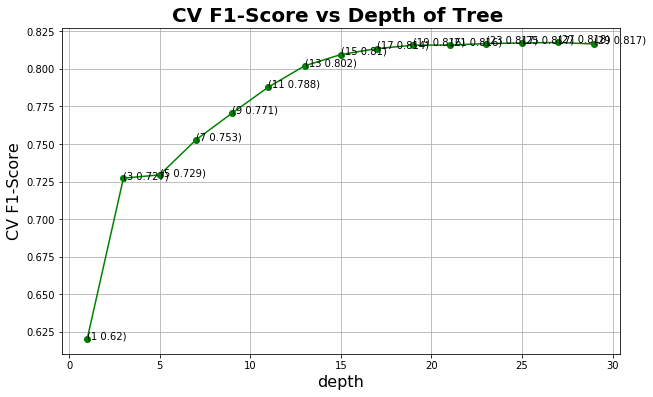

In [33]:
%%time
grid_estimator=DT_model(X_train_tfidfw2v,y_train)

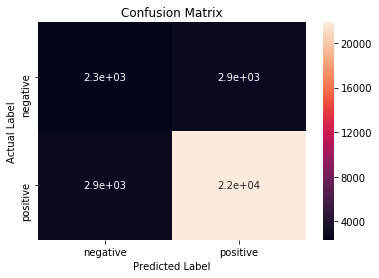

[[ 2336  2920]
 [ 2886 21858]]

Test Error : 0.194
Test Accuracy : 80.647 %
True Negative : 2336
False Positive : 2920
False Negative : 2886
True Positive : 21858
Precission Score : 0.806
Recall Score : 0.806
F1 Score : 0.806



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.45      0.44      0.45      5256
   positive       0.88      0.88      0.88     24744

avg / total       0.81      0.81      0.81     30000

CPU times: user 2.84 s, sys: 8 ms, total: 2.85 s
Wall time: 2.59 s


In [34]:
%%time
DT_Test(X_train_tfidfw2v, X_test_tfidfw2v, y_train, y_test) 

## [9] Conclusion : <a name="conclusion"></a>

| Featurization Model | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| <b>BOW(unigram)</b> | 77.963 % | 0.837  | 0.78 | 0.799 |
| <b>BOW(bigram)</b> | 79.107 % | 0.844  | 0.79 | 0.808 |
| <b>TF-IDF(unigram)</b> | 76.98 % | 0.835  | 0.77 | 0.791 |
| <b>TF-IDF(bigram)</b> | 78.043 % | 0.838  | 0.78 | 0.799 |
| <b>Average Word2Vec</b> | 81.43 % | 0.818  | 0.814 | 0.816 |
| <b>TF-IDF Weighted Word2Vec</b> | 80.647 % | 0.806  | 0.806 | 0.806 |

<br>
<b>1 - </b>Using Average Word2Vec model gives best performance with F1 score of <b>0.816</b>.

<b>2 - </b>It is also observed(in this case) that Decission Trees doesnot work fairly good with textdata because of high dimensions(as each unique word is considered as a feature).So the model gets more deep(in depth) which makes the model less interpretable.

<b>3 - </b>Run Time complexity of  Decission Trees is superfast, hence can be used for low latency applications.

<b>4 - </b>It is also observed using Decission Tree Classifier, Word2Vec models(AVerage w2v and Tfidf weighted w2v) perfoms better than Bag of Words and Tfidf.